In [346]:
import numpy as np 
from numpy import genfromtxt

import scipy  
from scipy.spatial import distance

import sklearn 
from sklearn.cluster import KMeans
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import mpld3
from mpld3 import plugins

import seaborn as sns
import pandas as pd 
import os
import h5py as h5py
import pickle
import timeit
import warnings

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers.core import Dropout, Activation, TimeDistributedDense, Dense
import theano

%matplotlib inline 

### V (vocab) is a list of 75,000 common word tokens.  L (labels) is a list of 1000 emoji.  The index position of each word in V and of each emoji in L is used as its integer representation in the tweet data (RandInputs and RandTargets).

In [ ]:
V = pickle.load(open('vocab.pickle', 'rb'))
L = pickle.load(open('labels.pickle', 'rb'))
L2=L[2:]

### RandInputs and RandTargets contain words and emoji, respectively, from 10,000 randomly selected tweets.  Each row of RandInputs contains a sequence of integers encoding word tokens from V (integer i represents the ith word in vocab list V).  Each row of RandTargets contains a sequence of integers encoding emoji from L (integer j represents the jth emoji in emoji list L).   RandInputs and RandTargets have 20 columns which are padded from left to right (starting at 0th column) with "non-coding" 0's (to accomadate for tweets having fewer than 20 words or tokens).

In [348]:
RandInputs = genfromtxt('RandInputs.csv', delimiter=',')
RandTargets = genfromtxt('RandTargets.csv', delimiter=',')
print(RandInputs.shape, RandTargets.shape)
n = RandInputs.shape[0]

### Call recurrent neural network model (not shown in this notebook), with the dimensions of the data as input arguments (len(V) is the number of word tokens and len(L) is the number of emoji).

In [349]:
model = RNN_model(len(V),len(L)) 
print(model)

### Load the weights of a recurrent neural network trained on millions of tweets (model training not shown in this notebook).

In [350]:
model.load_weights('trained_model.keras')
final_dense = model.layers[-2].W.eval()
final_dense = np.transpose(final_dense)

### Run the randomly sampled data through the model to get predicted emoji.

In [352]:
softmax = model.predict(RandInputs,verbose=0)

### Transpose softmax output so that emoji are rows.  Then delete first 2 rows, corresponding to '__NT__' and  '__COMBO__'  rather than true emoji.  While we are at it, create array FD2 holding final_dense without the first 2 rows, for the same reason.

In [353]:
softmax = np.transpose(softmax)
softmax=softmax[2:,:]
n=len(softmax)

FD2 = final_dense[2:,:]
print(final_dense.shape, FD2.shape)

###  Generate a normalized version of the transposed softmax output where each row is normalized to itself.

In [354]:
softmaxNorm=np.zeros(softmax.shape)
for i in np.arange(n):
    softmaxNorm[i,:]=softmax[i,:]/np.sum(softmax[i,:])

### Visualize 2D t-SNEs of the higher dimensional final dense layer trained weights using euclidean (graph on left) and correlation (graph on right) based distance metrics.

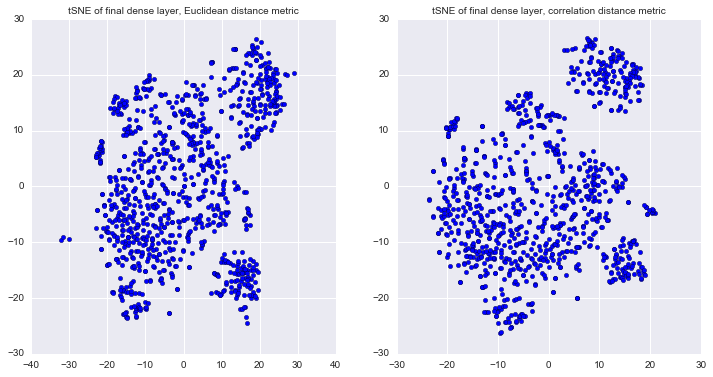

In [356]:
# tSNE with euclidean distance metric used
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
tSNE_model_Euc = TSNE(n_components=2, random_state=0, metric='euclidean')
tSNE_FD_Euc = tSNE_model_Euc.fit_transform(FD2) 
plt.scatter(tSNE_FD_Euc[:,0],tSNE_FD_Euc[:,1]) #,marker=label_dict)
plt.title("tSNE of final dense layer, Euclidean distance metric", size=10)

# tSNE with correlation-based distance metric used
plt.subplot(1,2,2)
tSNE_model_Cor = TSNE(n_components=2, random_state=0, metric='correlation')
tSNE_FD_Cor = tSNE_model_Cor.fit_transform(FD2) 
plt.scatter(tSNE_FD_Cor[:,0],tSNE_FD_Cor[:,1]) #,marker=label_dict)
plt.title("tSNE of final dense layer, correlation distance metric", size=10)


### Visualize 2D t-SNEs of softmax layer probabilities using euclidean (top graphs) and correlation (bottom graphs) based distance metrics.  Raw probabilities (left graphs) and normalized probabilities (right graphs) are shown.  

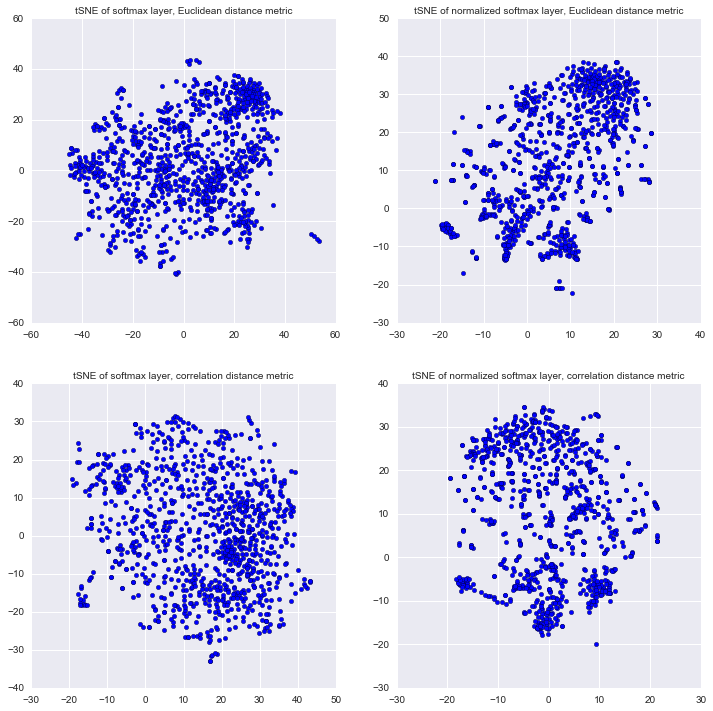

In [208]:
plt.figure(figsize=(12, 12))

# tSNE_model = TSNE(n_components=2, random_state=0, metric='cosine')

# 1. tSNE of softmax output (euclidean distance metric)
plt.subplot(2,2,1)
tSNE_SM_Euc = tSNE_model_Euc.fit_transform(softmax) # 2:,:]) 
plt.scatter(tSNE_SM_Euc[:,0],tSNE_SM_Euc[:,1]) #,marker=label_dict)
plt.title("tSNE of softmax layer, Euclidean distance metric", size=10)

# 2. tSNE of normalized softmax output (euclidean distance metric)
plt.subplot(2,2,2)
tSNE_SMNorm_Euc = tSNE_model_Euc.fit_transform(softmaxNorm) 
plt.scatter(tSNE_SMNorm_Euc[:,0],tSNE_SMNorm_Euc[:,1]) #,marker=label_dict)
plt.title("tSNE of normalized softmax layer, Euclidean distance metric", size=10)

# 3. tSNE of softmax output (correlation distance metric)
plt.subplot(2,2,3)
tSNE_SM_Cor = tSNE_model_Cor.fit_transform(softmax) # 2:,:]) 
plt.scatter(tSNE_SM_Cor[:,0],tSNE_SM_Cor[:,1]) #,marker=label_dict)
plt.title("tSNE of softmax layer, correlation distance metric", size=10)

# 4. tSNE of normalized softmax output (correlation distance metric)
plt.subplot(2,2,4)
tSNE_SMNorm_Cor = tSNE_model_Cor.fit_transform(softmaxNorm) 
plt.scatter(tSNE_SMNorm_Cor[:,0],tSNE_SMNorm_Cor[:,1]) #,marker=label_dict)
plt.title("tSNE of normalized softmax layer, correlation distance metric", size=10)


### Use mpld3 to visualize how emoji are distributed in a 2D t-SNE (hover mouse over points in plot below).  Set X to one of the selections (all but one commented out) to visualize emoji in different parameter spaces.  The final dense layer classifies emoji better than the softmax probabilities, even though the t-SNEs of the normalized softmax output (above) appear to cluster nicely.

In [357]:
# Comment/uncomment X = ___ assignments to select which parameter space to visualize

# X = tSNE_FD_Euc   # tSNE of final dense layer, using euclidean distance           
X = tSNE_FD_Cor       # tSNE of final dense layer, using correlation-based distance          
# X = tSNE_SM_Euc     # tSNE of softmax layer, using euclidean distance 
# X = tSNE_SMNorm_Euc   # tSNE of normalized softmax layer, using euclidean distance
# X = tSNE_SM_Cor      # tSNE of softmax layer, using correlation-based distance
# X = tSNE_SMNorm_Cor    # tSNE of normalized softmax layer, using correlation-based distance

fig, ax = plt.subplots(figsize=(5, 5)) #,subplot_kw=dict(axisbg='#EEEEEE'))

scatter = ax.scatter(X[:,0],X[:,1],s=30, alpha=0.30, c='red')
ax.grid(color='white', linestyle='solid')

# ax.set_title("tSNE of emoji from final dense layer of RNN", size=10)

labels = [L2[i] for i in np.arange(n)] 

tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=labels,voffset=-20, hoffset=20)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

# Hover mouse over plot below to visualize emoji

### Hover mouse over plot above to visualize emoji
###
###

###  Functions 'x2p' and 'Hbeta'  from the Python implementation of t-SNE by Laurens van der Maaten.  These functions produce an estimate of joint pairwise probabilities between points in an N-dimensional space using  gaussian kernels centered about each point (see https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), a suitable way to quantify similarity between emoji as evidenced by the t-SNE plot above.   

In [358]:
# The following is adapted directly from the python implementation of t-SNE 
# created by Laurens van der Maaten on 20-12-08 (see https://lvdmaaten.github.io/tsne/).
# (Copyright (c) 2008 Tilburg University.)

import numpy as np
import pylab as Plot

def Hbeta(D = np.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta);
    sumP = sum(P);
    H = np.log(sumP) + beta * np.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X = np.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape;
    sum_X = np.sum(np.square(X), 1);
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X);
    P = np.zeros((n, n));
    beta = np.ones((n, 1));
    logU = np.log(perplexity);

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point ", i, " of ", n, "...")

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf;
        betamax =  np.inf;
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy();
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i].copy();
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP;

    # Return final P-matrix
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)));
    P = P + np.transpose(P);
    # P = P / np.sum(P);
    # P = P * 4;   # early exaggeration
    # P = np.maximum(P, 1e-12);
    return P;


### Probability matrix P holds joint probabilities between emoji in the original (higher dimensional) parameter space of the final dense layer, generated by calling the x2p function that is used in the first step of t-SNE (see above).

In [359]:
# Call x2p function (above) to get joint probability matrix for all pairs of emoji  
P = x2p(FD2) 

# convert nans to 0s ... these correspond to emoji never observed in the training set,
# which result in divide-by-zero occurring in x2p and Hbeta functions
P[np.isnan(P)==True]=0 

Computing pairwise distances...
Computing P-values for point  0  of  998 ...
Computing P-values for point  500  of  998 ...
Mean value of sigma:  5.64345455732


### Similarity score S is the negative log of the pairwise joint probabilities generated using the t-SNE-based approach.

In [ ]:
S = -np.log10(P) 

### Visualize the pairwise distance matrix P and it's inverse log transform (the similarity score, S) with heatmaps.

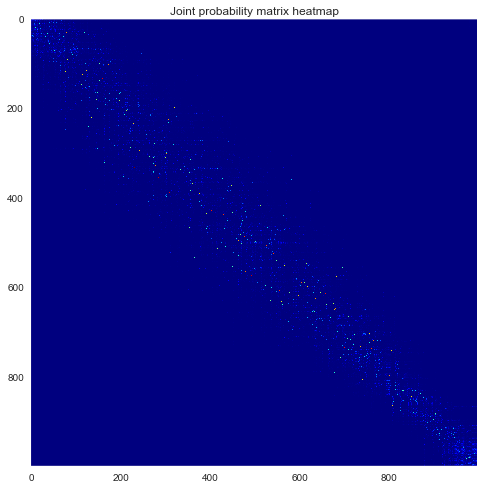

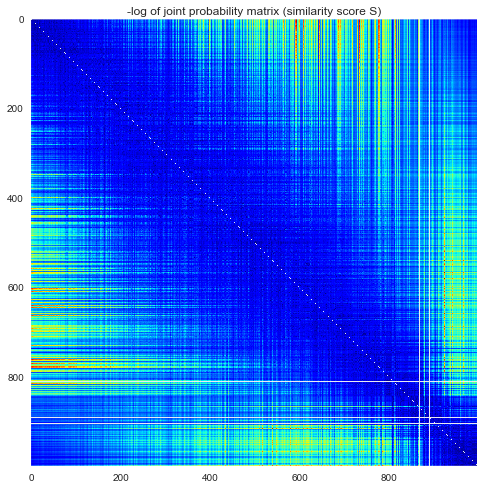

In [219]:
plt.figure(figsize=(8, 8))
plt.imshow(P, cmap='jet', interpolation='none')
plt.grid(False)
plt.title('Joint probability matrix heatmap')

plt.figure(figsize=(8, 8))
plt.imshow(S, cmap='jet', interpolation='none')
plt.grid(False)
plt.title('-log of joint probability matrix (similarity score S)')

### Inspect pairwise similarity score S between a few select emoji; more similar items have lower S. 

In [220]:
# Indices of select emoji for comparison
Indx1 = [758, 714, 110, 41, 73, 765]
Indx2 = [746, 715, 34, 94, 48, 717]

# DemoMtrxij to hold a probability matrix just for the examples provided in Indx1 and Indx2
DemoMtrxij = np.zeros((6,6))

for i in np.arange(6):
    for j in np.arange(6):
        if j==0:
            print()
        print(L2[Indx1[i]],L2[Indx2[j]],'| S =',S[Indx1[i],Indx2[j]])

        DemoMtrxij[i,j] = S[Indx1[i],Indx2[j]]

# Make a DF of DemoMtrxij
DemoDFij = pd.DataFrame(DemoMtrxij)

# Tried to set column and row names to emoji but no luck
# DemoDFij.columns = [ L2[Indx1[0]], L2[Indx1[1]], L2[Indx1[2]], L2[Indx1[3]], L2[Indx1[4]], L2[Indx1[5]] ]
print()
DemoDFij.head(6)


🕤 🕦 | S = 0.614606841679
🕤 ♎ | S = 3.42852736146
🕤 🎉 | S = 8.158263977
🕤 💓 | S = 8.5027509019
🕤 😄 | S = 8.51257525461
🕤 🇵🇷 | S = 2.92373407879

♐ 🕦 | S = 2.81571216392
♐ ♎ | S = 0.43138719934
♐ 🎉 | S = 8.20077211659
♐ 💓 | S = 8.36279209338
♐ 😄 | S = 8.94780006358
♐ 🇵🇷 | S = 2.21226806329

🎊 🕦 | S = 8.11856474828
🎊 ♎ | S = 7.79718964115
🎊 🎉 | S = 0.133836568744
🎊 💓 | S = 2.56586042529
🎊 😄 | S = 2.06100712198
🎊 🇵🇷 | S = 6.70748523904

💖 🕦 | S = 9.4644882799
💖 ♎ | S = 9.05429659646
💖 🎉 | S = 2.0192701371
💖 💓 | S = 0.877855129953
💖 😄 | S = 1.78143217581
💖 🇵🇷 | S = 8.48290265423

😃 🕦 | S = 8.60567491412
😃 ♎ | S = 8.57600012208
😃 🎉 | S = 2.19273420021
😃 💓 | S = 2.47479244595
😃 😄 | S = 0.281515480541
😃 🇵🇷 | S = 8.04716444791

🇨🇱 🕦 | S = 2.17072449116
🇨🇱 ♎ | S = 3.17978535397
🇨🇱 🎉 | S = 7.00129480834
🇨🇱 💓 | S = 7.59680914258
🇨🇱 😄 | S = 7.86513856999
🇨🇱 🇵🇷 | S = 0.120895676871



,0,1,2,3,4,5
0,0.614607,3.428527,8.158264,8.502751,8.512575,2.923734
1,2.815712,0.431387,8.200772,8.362792,8.947800,2.212268
2,8.118565,7.797190,0.133837,2.565860,2.061007,6.707485
3,9.464488,9.054297,2.019270,0.877855,1.781432,8.482903
4,8.605675,8.576000,2.192734,2.474792,0.281515,8.047164
5,2.170724,3.179785,7.001295,7.596809,7.865139,0.120896


### The diversifier function generates the RNN-based ranking of emoji (a and aIndx) for a single tweet input and also reranks the original ranking to produce a more diverse ranking based on the similarity score S (b and bIndx).  
### The reranking is as follows:  For the first 15 positions in the RNN-based ranking (presumably comprising everything that would be displayed by the app), the diversifier searches down the list for the next highest ranked emoji that is not too similar to the preceding one(s) (according to threshold T, memory parameter M, and operation Op (mean or min)).  The first emoji to meet this criterion is moved to next in the ranking, and the process is continued recursively for this next position in the ranking.

In [221]:
# Input arguments:   
# S         :   Matrix holding S scores (-log of pairwise joint probabilities) for all pairs of emoji
# textinput :   Row sequence of integers representing tokens of a text input (e.g., a tweet)
# T         :   Threshold value that S score must be above for neighboring emoji
# M         :   Memory value describes how many preceding emoji are compared to the jth emoji with respect to S score
# Op        :   Operation to impose on preceding M emoji for for comparing S score (select 'min' or 'mean')

def diversifier(S = S, textinput = ['I', 'love'], T = 2, M = 3, Op='mean'):
    
    X = model.predict(textinput,verbose=0) # call the model to get the RNN softmax output for textinput, assign as X
    X = X[:,2:] # get rid of first 2 rows corresponding to 'NT' and 'COMBO'
    
    # generate highest-to-lowest ranking of softmax output by sorting X 
    # the "a" version will remain un-changed
    a=np.sort(X[0,:])[::-1] # ranked values
    aIndx=np.argsort(X[0,:])[::-1] # .astype(int) # ranked index

    # the "b" version will be re-ranked 
    b = a.copy() # np.zeros(a.shape)
    bIndx = aIndx.copy() # np.zeros(aIndx.shape)
    
    # Loops to re-rank emoji in bIndx 
    for i in np.arange(15): # only need to rerank top ~15 items to handle what is displayed by the app

        j = i+1 # start by comparing, e.g., 2nd ranked to 1st ranked emoji 
        
        LB = np.max([j-M,0]) # lower bound LB to avoid out of bounds error where j-M<0 
        
        # get the mean of the distances from jth ranked emoji to preceding emoji
        # alternatively you can use np.min instead of np.mean, but this will makes the reranking much more stringent
        if Op == 'mean':
            dist = np.mean( S[ bIndx[LB:j] , bIndx[j] ] ) 
        elif Op == 'min':
            dist = np.min( S[ bIndx[LB:j] , bIndx[j] ] ) 

        while dist<T and j<=len(S):
            j+=1
            dist = np.min( S[ bIndx[LB:j] , bIndx[j] ] ) 
        
        bIndx = np.append(np.insert(bIndx[:j],i+1,bIndx[j]) , bIndx[j+1:]) 
    return aIndx, bIndx

### Get index of emoji in vocab to remove emoji from original tweet inputs.

In [308]:
VemojiIndx = np.asarray( [i for (i,v) in enumerate(V) if v in L] )
BadIndx = np.append([0,1],VemojiIndx)

### Feed in tweets and examine compare the reranked output to the original.  Note importance of selecting suitable values for threshold T, memory parameter M, and operation Op (see comments below).

In [345]:
# Set similarity threshold T.  
# If T is set too low the reranker won't do much, if anything 
# If T is set too high the reranker will force so much diversity that accuracy will suffer
# From about T=1 to about T=1.5 seems like the right range to explore in
T=1.5 # 1.0 # 1.1 # 1.2 # 1.3 # 1.4 # 1.5

# Set Memory parameter M.  
# It roughly determines how many emoji, on average, separate "similar" emoji in the ranking
# E.g., if set to 1, the ranking could theoretically go clock/heart/clock/heart...
# 3 seems like a pretty good amount of memory.  
# Note though that there are "edge" effects near the beginning of the ranking
# (for example you can't average over the preceding 3 emoji when you're at the 2nd or 3rd ranked emoji)
M=2 # 2 # 3 

# Set operation Op.  
# If set to 'mean' the algorithm will compute the AVERAGE S score between jth emoji and preceding M emoji 
# If set to 'min' the algorithm will compute the MINIMUM S score between jth emoji and preceding M emoji 
Op = 'mean' # 'min'


# loop through some of the randomly selected tweets to compare a modified ranking algorithm to the original
for k in np.arange(100):
    #if k in [4, 17, 60, 90, 92, 94, 97]:
        textinput =  RandInputs[k,:].astype(int)  

        # remove emoji from textinput using VemojiIndx, 
        # which holds indices for all emoji in V, which holds the set of all tokens 
        textinput_cut = np.asarray( [[v for (i,v) in enumerate(textinput) if v not in VemojiIndx] ] )

        aIndx, bIndx = diversifier(S, textinput_cut, T, M, Op) #  get original and modified ranking by calling diversifier

        if aIndx.all()!=bIndx.all(): # why is this broken?
            Diffs[k,1]+=1


        tokens = textinput_cut[textinput_cut>2]

        print(k) # print row ID for this random input tweets
        for c in np.arange(len(tokens)): # print the tokenized tweet (filler already removed)
            print(V[tokens[c]], end=" ")
        print() 
        for c in np.arange(15): # print the tokenized tweet (filler already removed)
            print(L2[aIndx[c]], end=" ")
        print() 
        for c in np.arange(15): # print the tokenized tweet (filler already removed)
            print(L2[bIndx[c]], end=" ")
        print() 

# Displayed below:          
# Row ID
# Tweet
# Original ranking
# Rerank

0
so work wanna give me a 12 10 shift today ? 
😒 😑 😩 😂 😭 😔 😐 😕 😅 😊 😡 😳 😏 😁 😞 
😒 💰 😑 😩 💸 😂 😭 🆒 😔 😐 😊 😡 😕 😅 💵 
1
i just wanna laying down but i can ' t 
😩 😔 😭 😒 😢 😞 😫 😕 😂 😣 😪 😓 😑 😐 😥 
😩 🎶 😔 😭 🎧 😒 😢 🎵 😞 😫 ☀ 😕 😂 😣 ☔ 
2
really missing the bucks from earlier 
😔 😢 😭 😞 😂 😕 😒 😩 😊 ❤ 😥 👍 😁 💔 🙏 
😔 ❤ 😢 👍 🌹 😭 😞 🏀 😂 😕 🔯 😒 😩 😊 😥 
3
i ' m looking forward to friday night lights with you bro let ' s eat 
🍴 🏈 😂 👌 😍 😈 😋 😁 🏀 💯 🙌 😏 👍 😊 👏 
🍴 🏈 😂 👌 😈 😍 🏀 😋 😁 💯 🍗 🙌 😏 🍕 👍 
4
. . didn ' t help relax me too much but i ' m oiled up smelling like coconuts 
😂 😋 😍 😩 😏 😊 ☺ 😌 😁 💁 😝 😜 😭 😒 😎 
😂 😋 🌴 😍 😩 🌺 😏 😊 🎶 🌰 ☺ 😌 🍈 😁 💁 
5
mrs papa loves me more than therese 
❤ ♥ 😂 😘 💕 😍 😊 😉 ☺ 💙 💖 😏 😁 😃 💜 
❤ 😂 💔 ♥ 😘 🎶 💏 💕 😍 😊 💑 😉 ☺ 💙 👫 
6
while tristan was sleeping all night . i was up tossing and turning . 
😒 😩 😔 😂 😑 😭 😞 😐 😕 😣 😫 😳 😡 😪 😓 
😒 🎶 😩 😔 ❤ 😂 😑 👣 😭 😞 😐 😡 🆒 😕 😣 
7
you can just not come anymore i will ride the bus home from now on . 
😂 😒 🚌 🚍 👌 😊 ✌ 💯 😡 😭 ✋ 😁 😏 😩 👍 
😂 🚌 😒 🚍 👌 😊 😡 ✌ 💯 😭 ✋ 😑 😁 🚎 😏 
8
got to see the baby . . he is ador

### Optionally feed in other token sequences as input and examine output.

In [302]:
# textinput =  ['what','time','is','it']
textinput=np.asarray([[V.index('what'), V.index('time'), V.index('is'), V.index('the')]]) 
textinput=np.asarray([[V.index('zodiac'), V.index('sign')]]) 
textinput=np.asarray([[V.index('i'), V.index('love')]]) 
#textinput=np.asarray([[V.index('i'), V.index('hate')]]) 


aIndx, bIndx = diversifier(S, textinput, 1.2, 3, 'min') #  get original and modified ranking by calling diversifier

if aIndx.all()!=bIndx.all(): # why is this broken?
    Diffs[k,1]+=1

tokens = textinput[textinput>2] # ignore the "filler" tokens used for short tweets

print(k)
for c in np.arange(len(tokens)): # print the tokenized tweet (filler already removed)
    print(V[tokens[c]], end=" ")

# print the orignal and reranked emoji for comparison
print()
print('Original: ', L2[aIndx[0]],L2[aIndx[1]],L2[aIndx[2]],L2[aIndx[3]],L2[aIndx[4]],L2[aIndx[5]],
      L2[aIndx[6]],L2[aIndx[7]],L2[aIndx[8]],L2[aIndx[9]],L2[aIndx[10]],L2[aIndx[11]],L2[aIndx[12]])
print()
print('Reranked: ', L2[bIndx[0]],L2[bIndx[1]],L2[bIndx[2]],L2[bIndx[3]],L2[bIndx[4]],L2[bIndx[5]],
      L2[bIndx[6]],L2[bIndx[7]],L2[bIndx[8]],L2[bIndx[9]],L2[bIndx[10]],L2[bIndx[11]],L2[bIndx[12]])

99
i love 
Original:  ❤ 😍 ♥ 💕 😂 💖 😘 💘 🍕 💗 😭 😊 💜

Reranked:  ❤ 🍕 😊 💏 😍 ♥ 💘 🍫 💕 😂 😻 💯 💖
